# Data coverage & quality

In this notebook we will go through the data tables that are used in analytics and modeling and check the coverage and quality of the data.

## Brief overview
In this notebook we primarily check for each generated data table,whether the data is missing or set to default value. We exclude all non-EUTOPIA-an affiliated articles from the analysis. Key takeaways are:
1. **Article dimension:** 
    - the majority of articles are written in English (*96.0%*) and have sufficient textual data available for analysis (*94.5%*),
    - almost *60%* of articles are open access, the same as the percentage of articles with abstract,
    - *81.4%* of articles have the references available, but references are avaialable in two different ways: a list of DOIs or a list of titles, where this will probably need to be unified,
    - only *1%* of articles are EUTOPIA-an collaborations.
2. **Author dimension:** ORCID ID is only available for *16.5%* of authors, hence this will either need to be enriched or the data source will not significantly contribute to the analysis.
3. **Collaboration novelty index:** The distribution of the collaboration novelty index is skewed to the left, with the majority of values between *0* and *10*, it is almost exponential distribution with a peak at *0*.

Considering the data coverage and quality, we will define **the notion of relevant articles** as articles that:
1. Are published by EUTOPIA institutions.
2. Have either full text, abstract or references available to ensure sufficient textual data for embeddings.
3. Are written in English.
---
**INFO**

This brings us to the coverage of *91.6% (=147K)* of relevant articles comparing to all EUTOPIA-affiliated articles.

---


## Global imports & settings

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from box import Box
import sqlalchemy

from util.notebooks.data_coverage import plot_health_metrics
from util.postgres import create_sqlalchemy_connection, query

In [3]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yaml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize Postgres connection
pg_conn = create_sqlalchemy_connection(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)

# Define the color palette
palette = {'good': config.DASHBOARD.COLORS.GOOD_COLOR,
           'warning': config.DASHBOARD.COLORS.WARNING_COLOR,
           'bad': config.DASHBOARD.COLORS.BAD_COLOR}
DEFAULT_VALUE = 'n/a'

## DIM_ARTICLE

Read the `DIM_ARTICLE` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [4]:
query_article = f"""
SELECT *
FROM dim_article
"""

df_article = query(conn=pg_conn, query_str=query_article)
df_article.head(10)

,article_id,article_doi,article_eid,article_title,article_journal_title,article_publication_dt,article_keywords,article_language,is_single_author_collaboration,is_internal_collaboration,is_external_collaboration,is_eutopia_collaboration
0,85138100631,10.1016/j.algal.2022.102840,2-s2.0-85138100631,Exploring relationships between seaweeds carra...,Algal Research,2022-09-01,"{seaweeds,carrageenan,""mastocarpus stellatus"",...",en,False,False,True,False
1,77951214682,10.1111/j.1742-4658.2010.07619.x,2-s2.0-77951214682,Tetracysteine-tagged prion protein allows disc...,FEBS Journal,2010-05-01,"{protein,prion,tetracysteine,amyloid,fibril}",en,False,True,False,False
2,85034758620,10.1071/CH17456,2-s2.0-85034758620,Effect of structured surfaces on MALDI analyte...,Australian Journal of Chemistry,2017-01-01,"{""structured surfaces"",malDI,peptide,""surface ...",en,False,False,True,False
3,2-s2.0-77149140112,n/a,2-s2.0-77149140112,Raman characterization of MoS<inf>2</inf> micr...,Physica Status Solidi (B) Basic Research,2009-01-01,"{""raman spectroscopy"",""molybdenum disulfide"",m...",n/a,False,False,True,False
4,41549165223,10.1111/j.1742-4658.2008.06324.x,2-s2.0-41549165223,Crystal structure of a cold-adapted class C β-...,FEBS Journal,2008-04-01,"{""crystal structure"",""beta lactamase"",enzymes,...",n/a,False,False,True,False
5,85105716454,10.1088/1367-2630/abeffc,2-s2.0-85105716454,On the triad transfer analysis of plasma turbu...,New Journal of Physics,2021-04-01,"{""plasma turbulence"",symmetrization,""coarse gr...",en,False,False,True,False
6,85044540739,n/a,2-s2.0-85044540739,Evaluation of the levels of safety at railway ...,European Transport - Trasporti Europei,2018-03-01,"{""railway level crossings"",""data envelopment a...",en,False,True,False,False
7,2-s2.0-85028327163,n/a,2-s2.0-85028327163,"Body condition, diet and ecosystem function of...",Global Ecology and Conservation,2017-01-01,"{""red deer"",conservation,ecology,ecosystem,bio...",n/a,False,False,True,False
8,85094175750,10.1007/978-981-15-5862-7_20,2-s2.0-85094175750,Development of a Novel Viscoelastic Nanocompos...,Lecture Notes in Mechanical Engineering,2021-01-01,"{""polymer-based composite"",""nanoparticle inclu...",en,False,False,True,False
9,85139034828,10.2979/israelstudies.27.3.09,2-s2.0-85139034828,The Long History of the Mizrahim: New Directio...,Israel Studies,2022-09-01,"{""jewish history"",""mizrahi jews"",""israeli cine...",en,True,False,False,False


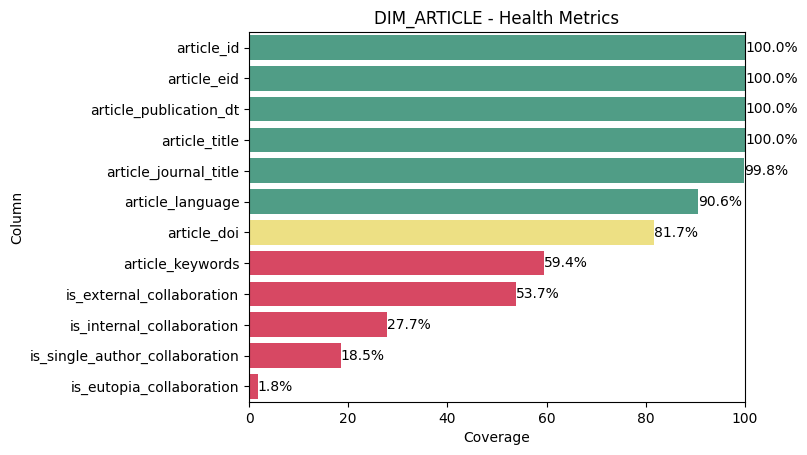

In [5]:
plot_health_metrics(df_source=df_article,
                    table_name='DIM_ARTICLE',
                    default_value=DEFAULT_VALUE,
                    palette=palette)

### Defining articles for final analysis

After checking base data coverage, we will check how many articles were published by EUTOPIA institutions. This will serve as baseline for further data coverage analysis.
We will then check the following:
1. For how many articles we have the full text available.
2. How many articles are written in English?
3. For how many articles we already have the embeddings available.


In [6]:
query_articles_eutopia = f"""
SELECT COUNT(DISTINCT f.article_id) AS article_count
FROM fct_collaboration f
    INNER JOIN dim_article a USING (article_id)
"""

df_articles_eutopia = query(conn=pg_conn, query_str=query_articles_eutopia)
n_relevant_articles = df_articles_eutopia.iloc[0, 0]
print(f"Number of articles published by EUTOPIA institutions: {n_relevant_articles}")

Number of articles published by EUTOPIA institutions: 416085


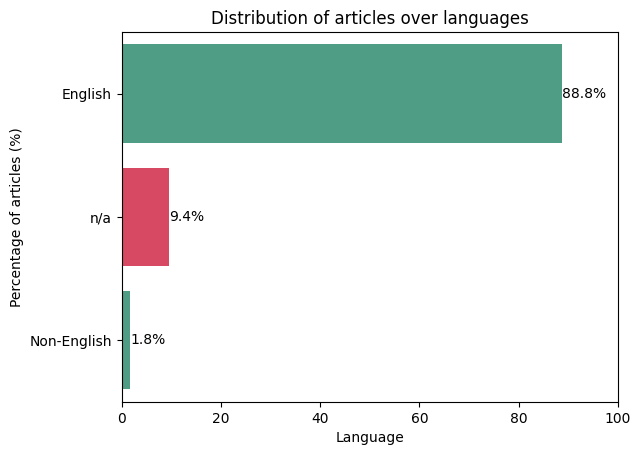

In [7]:
# Show article distribution (in %) over languages (df_article.ARTICLE_LANGUAGE) and show 'n/a' with bad color

# Split to 3 groups: English, Non-English and 'n/a'
df_article['article_language_group'] = df_article['article_language'].apply(
    lambda x: 'English' if x == 'en' else 'Non-English' if x != DEFAULT_VALUE else DEFAULT_VALUE)

# Plot the distribution of articles over languages
ax = sns.barplot(y=df_article['article_language_group'].value_counts(normalize=True).index,
                 x=100 * df_article['article_language_group'].value_counts(normalize=True).values,
                 hue=df_article['article_language_group'].value_counts(normalize=True).index,
                 palette=[palette['good'] if x != DEFAULT_VALUE else palette['bad']
                          for x in df_article['article_language_group'].value_counts(normalize=True).index])
plt.xlabel('Language')
plt.ylabel('Percentage of articles (%)')
plt.title('Distribution of articles over languages')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge')
plt.xlim(0, 100)
plt.show()

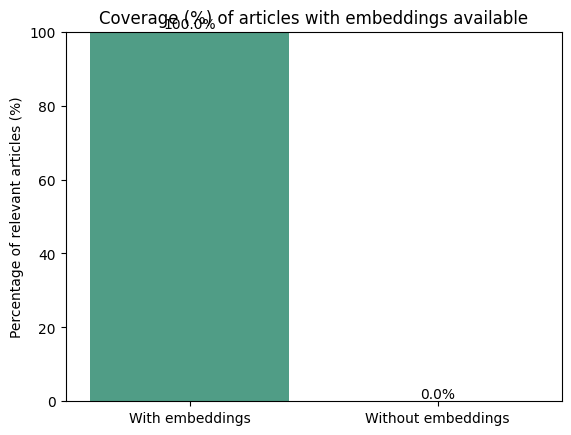

In [8]:
# Check how for how many articles we have the embeddings available
query_articles_embeddings = f"""
SELECT
    COUNT(DISTINCT f.article_id) AS article_count
FROM
    fct_collaboration f
    INNER JOIN dim_article a 
    ON f.article_id = a.article_id 
    INNER JOIN article_text_embedding e
    ON e.article_id = a.article_id
"""

df_articles_embeddings = query(conn=pg_conn, query_str=query_articles_embeddings)
n_articles_with_embeddings = df_articles_embeddings.iloc[0, 0]

# Visualize the coverage of articles with embeddings available
ax = sns.barplot(x=['With embeddings', 'Without embeddings'],
                 y=[100 * n_articles_with_embeddings / n_relevant_articles,
                    100 * (n_relevant_articles - n_articles_with_embeddings) / n_relevant_articles],
                 hue=['With embeddings', 'Without embeddings'],
                 palette=[palette['good'], palette['bad']])
# Add the data labels to the plot (truncated to 0 decimal points)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge')
plt.ylabel('Percentage of relevant articles (%)')
plt.title('Coverage (%) of articles with embeddings available')
plt.ylim(0, 100)
plt.show()

Given the data coverage, we see several bottlenecks on the data availability. To improve our dataset we will redefine the notion of relevant articles as articles that:
1. Are published by EUTOPIA institutions.
2. Have title available.
3. Have one of the following available: full text, abstract or references.
4. Are written in English.
5. Have the embeddings available. (TODO: this check will be added later as the data is not available yet) 

## DIM_AUTHOR
Read the `DIM_AUTHOR` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [13]:
query_author = f"""
SELECT *
FROM dim_author
"""

df_author = query(conn=pg_conn, query_str=query_author)
df_author.head(10)

,author_id,author_name
0,21740748300,Arnillas M.P.G.
1,55396203600,Dudic D.
2,6506975424,Castillejo-Lopez C.
3,57575757100,Logar N.Z.
4,35301576700,de Hollander E.L.
5,57224082233,Petrinic S.
6,6603292835,Weidig R.
7,6603268028,Sjalander A.
8,35956081000,Forsman L.
9,35741623700,Prezzi D.


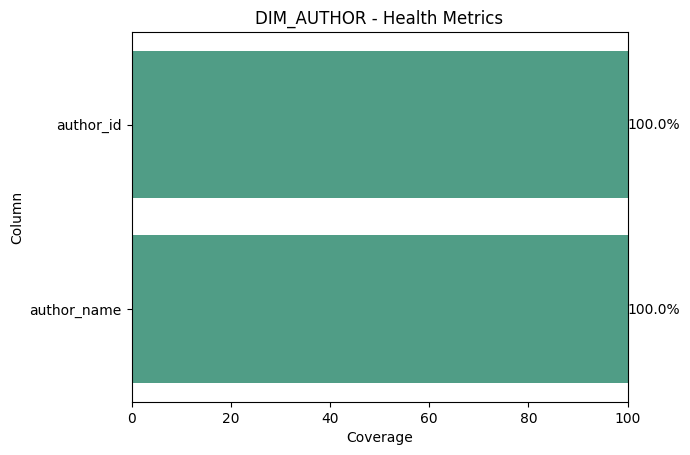

In [14]:
plot_health_metrics(df_source=df_author,
                    table_name='DIM_AUTHOR',
                    default_value=DEFAULT_VALUE,
                    palette=palette)

## FCT_COLLABORATION
Read the `FCT_COLLABORATION` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [15]:
query_collaboration = f"""
SELECT *
FROM fct_collaboration
"""

df_collaboration = query(conn=pg_conn, query_str=query_collaboration)
df_collaboration.head(10)

,article_id,author_id,research_area_code,author_sequence_type,institution_id,article_publication_dt,is_eutopia_collaboration,is_single_author_collaboration,is_internal_collaboration,is_external_collaboration,has_new_author_collaboration,has_new_institution_collaboration,author_article_count
0,85128915180,57196189499,B540,middleAuthor,WARWICK,2022-12-01,False,False,False,True,False,True,9
1,85020093787,35094618200,B770,singleAuthor,TU_DRESDEN,2017-09-01,False,False,False,True,False,True,18
2,84957701769,57201069236,B680,middleAuthor,OTHER,2016-02-01,True,False,False,True,True,True,9
3,85009288455,55199382800,T125,firstAuthor,TU_DRESDEN,2017-04-01,False,False,False,True,False,True,1
4,84880556056,9244824900,P395,firstAuthor,UBBCLUJ,2013-07-22,False,False,True,False,False,False,18
5,77950402845,6603503347,B191,middleAuthor,OTHER,2010-03-23,False,False,False,True,True,True,0
6,85107577457,6506215260,B200,middleAuthor,TU_DRESDEN,2021-08-01,True,False,False,True,True,True,0
7,85059336540,6602980884,B110,middleAuthor,GU,2018-12-01,False,False,False,True,True,True,25
8,79955594736,7102536732,S262,middleAuthor,GU,2011-01-01,False,False,False,True,True,True,0
9,58149234108,22978843900,P430,firstAuthor,OTHER,2009-01-30,False,False,False,True,True,True,2


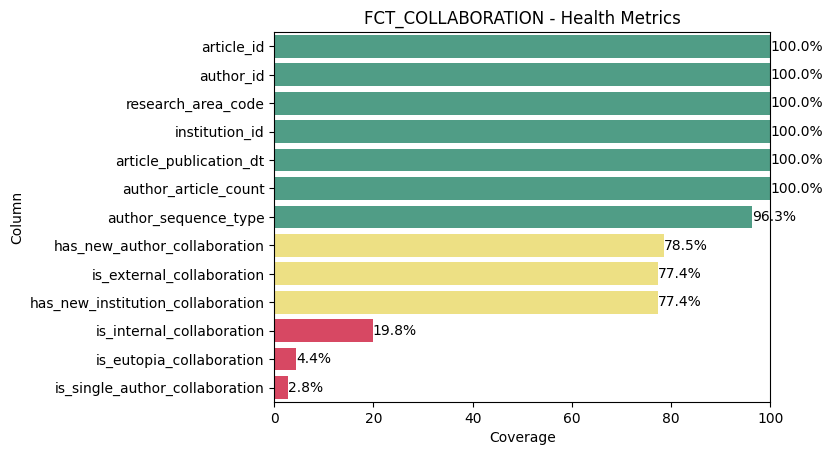

In [16]:
plot_health_metrics(df_source=df_collaboration,
                    table_name='FCT_COLLABORATION',
                    default_value=DEFAULT_VALUE,
                    palette=palette)

## FCT_COLLABORATION_NOVELTY
Read the `FCT_COLLABORATION_NOVELTY` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [17]:
query_article = f"""
SELECT *
FROM fct_article
"""

df_article = query(conn=pg_conn, query_str=query_article)
df_article.head(10)

,article_id,research_area_code,article_citation_count,article_citation_normalized_count,article_publication_dt,is_eutopia_collaboration,is_single_author_collaboration,is_internal_collaboration,is_external_collaboration,is_new_collaboration,collaboration_novelty_index
0,85132338055,H440,0,0.00,2021-12-01,False,True,False,False,None,0.000000
1,65249116981,B490,140,36.66,2009-03-01,False,False,True,False,True,1.750000
2,85018362484,P211,58,16.19,2017-01-01,False,False,False,True,True,52.502797
3,2-s2.0-85115998003,P510,0,0.00,2021-01-01,False,False,False,True,True,1.000036
4,84882441708,B640,0,0.00,2010-12-01,False,False,False,True,True,0.666787
5,63749121113,T290,19,7.33,2009-04-09,False,False,False,True,True,6.000000
6,85085644187,T150,36,10.13,2020-07-01,True,False,False,True,True,1.144428
7,85028701121,P176,4,1.59,2017-01-01,False,False,False,True,True,1.000203
8,85064622456,S210,13,7.12,2019-01-01,False,True,False,False,None,0.000000
9,2-s2.0-85071141360,P320,0,0.00,2019-10-01,False,False,False,True,True,1.000000


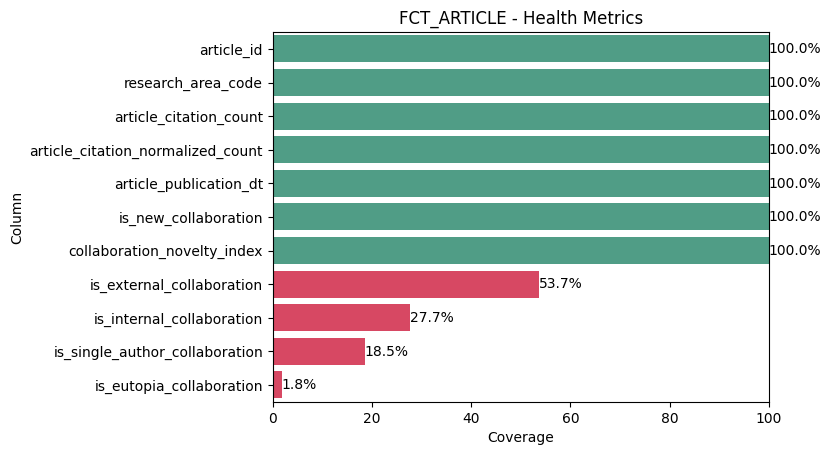

In [18]:
plot_health_metrics(df_source=df_article,
                    table_name='FCT_ARTICLE',
                    default_value=DEFAULT_VALUE,
                    palette=palette)